<a href="https://colab.research.google.com/github/ultra151/cv/blob/main/8_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


--2024-11-15 10:14:59--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-11-15 10:15:00--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  26.3MB/s    in 29s     

2024-11-15 10:15:30 (25.7 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2024-11-15 10:15:30--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.r

In [ ]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [ ]:
import os

current_dir = os.getcwd()
print("Current working directory:", current_dir)

Current working directory: /content


In [ ]:
!ls

annotations  annotations.tar.gz  images  images.tar.gz	sample_data


In [ ]:
print(os.listdir("images"))

['english_cocker_spaniel_192.jpg', 'english_setter_30.jpg', 'Ragdoll_183.jpg', 'pomeranian_184.jpg', 'Ragdoll_264.jpg', 'japanese_chin_36.jpg', 'Ragdoll_159.jpg', 'Bengal_146.jpg', 'leonberger_1.jpg', 'Egyptian_Mau_43.jpg', 'pug_109.jpg', 'leonberger_6.jpg', 'Birman_107.jpg', 'Bengal_54.jpg', 'havanese_20.jpg', 'Ragdoll_27.jpg', 'Persian_13.jpg', 'havanese_54.jpg', 'beagle_49.jpg', 'Siamese_175.jpg', 'Ragdoll_156.jpg', 'beagle_78.jpg', 'keeshond_68.jpg', 'Sphynx_170.jpg', 'keeshond_59.jpg', 'Maine_Coon_128.jpg', 'shiba_inu_147.jpg', 'Siamese_141.jpg', 'american_pit_bull_terrier_107.jpg', 'Bengal_93.jpg', 'Maine_Coon_140.jpg', 'german_shorthaired_12.jpg', 'keeshond_99.jpg', 'beagle_169.jpg', 'great_pyrenees_61.jpg', 'boxer_196.jpg', 'wheaten_terrier_7.jpg', 'wheaten_terrier_126.jpg', 'British_Shorthair_129.jpg', 'american_bulldog_150.jpg', 'boxer_91.jpg', 'american_bulldog_33.jpg', 'miniature_pinscher_66.jpg', 'Birman_141.jpg', 'Persian_42.jpg', 'Egyptian_Mau_180.jpg', 'great_pyrenees_1

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
annotation_file = 'annotations/trimaps/Abyssinian_1.png'
annotation_image = Image.open(annotation_file)
annotation_array = np.array(annotation_image)

unique_values = np.unique(annotation_array)
print("Unique values in the annotation image:", unique_values)

Unique values in the annotation image: [1 2 3]


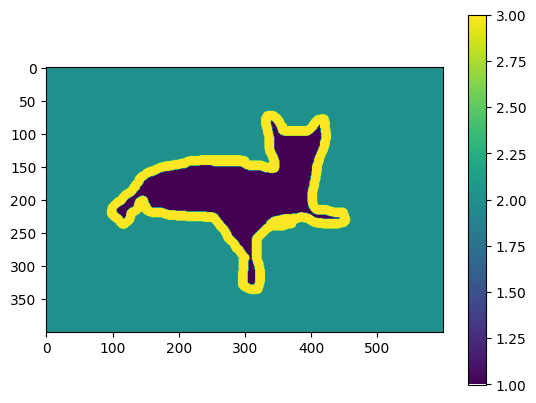

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(annotation_array, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
#print(annotation_array)

In [ ]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

In [ ]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [ ]:
input_img_paths[:3]

['images/Abyssinian_1.jpg',
 'images/Abyssinian_10.jpg',
 'images/Abyssinian_100.jpg']

In [ ]:
print("입력 샘플의 수:", len(input_img_paths))
print("타겟 샘플의 수:", len(target_img_paths))

입력 샘플의 수: 7390
타겟 샘플의 수: 7390


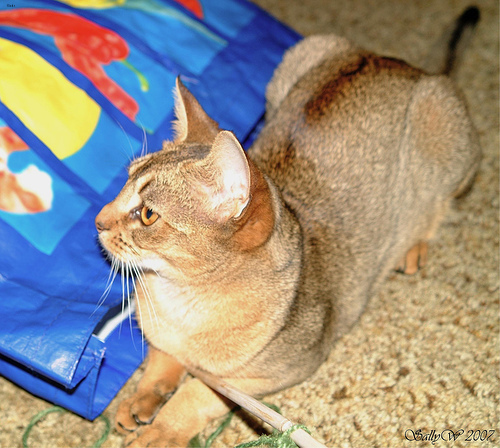

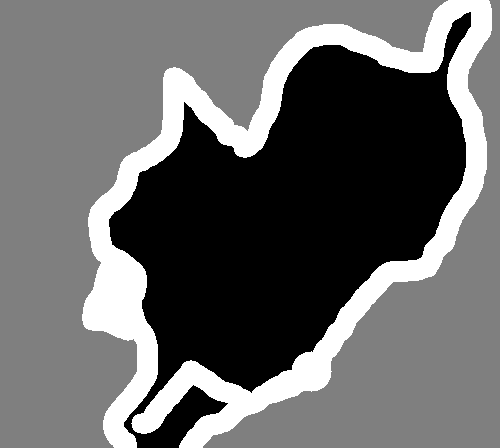

In [ ]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

display(Image(filename=input_img_paths[9]))

img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [ ]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


In [ ]:
def get_dataset(batch_size, img_size, input_img_paths, target_img_paths, max_dataset_len=None):

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_jpeg(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        target_img -= 1
        return input_img, target_img

    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]

    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


In [ ]:
import tensorflow as tf
import numpy as np

data = np.array([1,2,3,4,5])

dataset = tf.data.Dataset.from_tensor_slices(data)
print(type(dataset))

for element in dataset:
    print(element.numpy())

<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>
1
2
3
4
5


In [ ]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

In [ ]:
model = get_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 80, 80, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 80, 80, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 80, 80, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 80, 80, 32)     │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 80, 80, 64)     │          2,400 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 80, 80, 64)     │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 80, 80, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 80, 80, 64)     │          4,736 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 80, 80, 64)     │            256 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 40, 40, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 40, 40, 64)     │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 40, 40, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 40, 40, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 40, 40, 128)    │          8,896 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

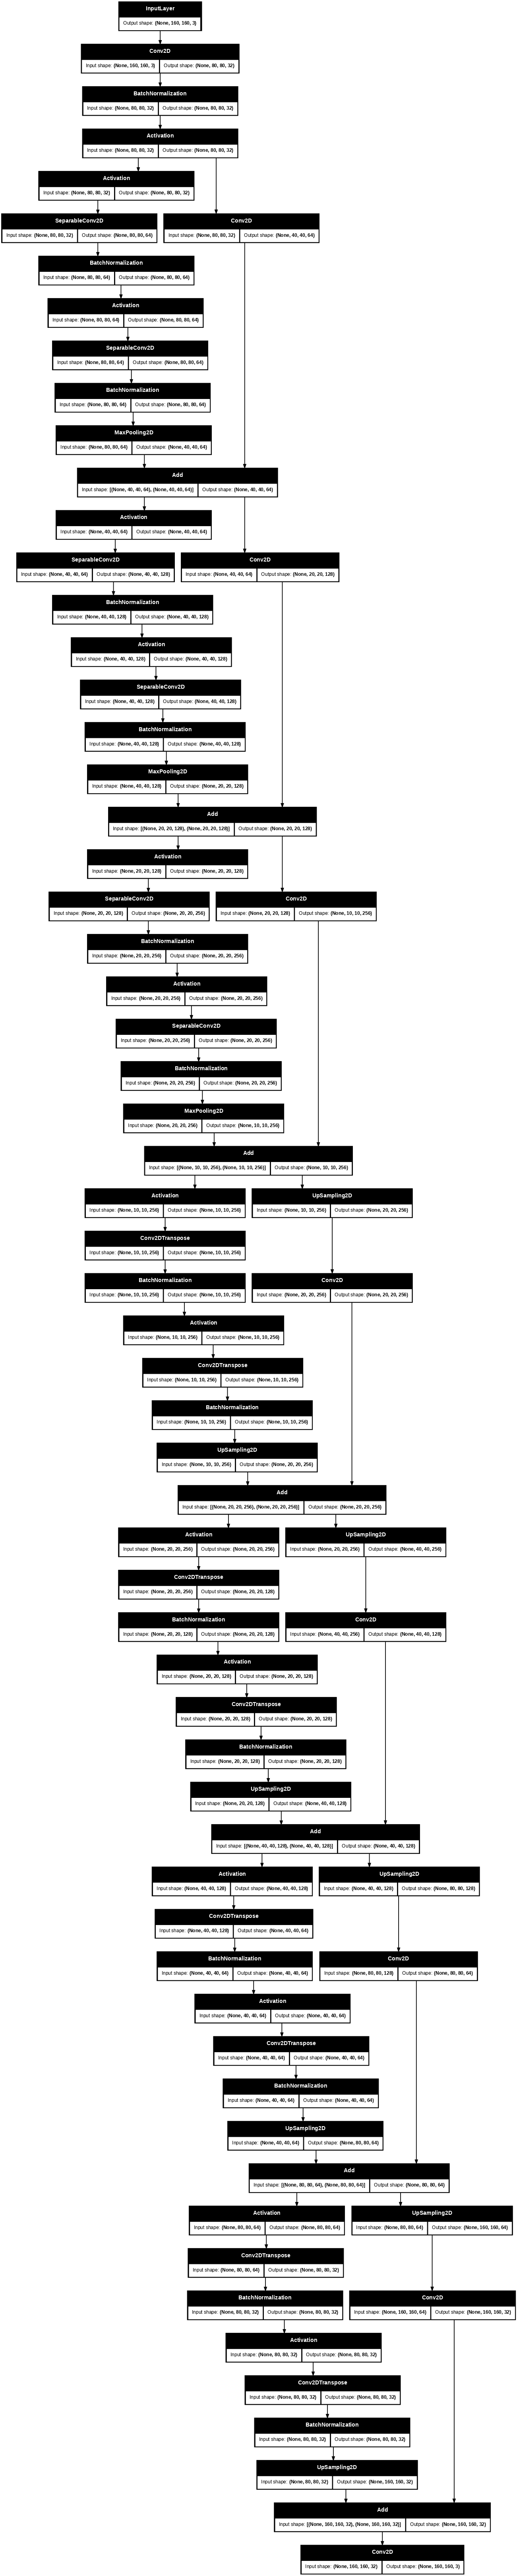

In [ ]:
import tensorflow as tf

tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
import random
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_dataset = get_dataset(batch_size, img_size, train_input_img_paths, train_target_img_paths, max_dataset_len=1000)
valid_dataset = get_dataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy")
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)]

epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50
32/32 - 61s - 2s/step - loss: 1.9212 - val_loss: 2.1657
Epoch 2/50
32/32 - 42s - 1s/step - loss: 0.9770 - val_loss: 1.6806
Epoch 3/50
32/32 - 6s - 186ms/step - loss: 0.8176 - val_loss: 2.2693
Epoch 4/50
32/32 - 8s - 247ms/step - loss: 0.7351 - val_loss: 2.9682
Epoch 5/50
32/32 - 6s - 187ms/step - loss: 0.6799 - val_loss: 3.6959
Epoch 6/50
32/32 - 9s - 266ms/step - loss: 0.6380 - val_loss: 4.4490
Epoch 7/50
32/32 - 8s - 238ms/step - loss: 0.6031 - val_loss: 5.2196
Epoch 8/50
32/32 - 9s - 286ms/step - loss: 0.5720 - val_loss: 5.9812
Epoch 9/50
32/32 - 6s - 186ms/step - loss: 0.5430 - val_loss: 6.7165
Epoch 10/50
32/32 - 10s - 319ms/step - loss: 0.5149 - val_loss: 7.4263
Epoch 11/50
32/32 - 8s - 241ms/step - loss: 0.4870 - val_loss: 8.1363
Epoch 12/50
32/32 - 8s - 265ms/step - loss: 0.4592 - val_loss: 8.7904
Epoch 13/50
32/32 - 10s - 322ms/step - loss: 0.4316 - val_loss: 9.3168
Epoch 14/50
32/32 - 12s - 371ms/step - loss: 0.4049 - val_loss: 9.5634
Epoch 15/50
32/32 - 10s - 304m

In [ ]:
val_dataset = get_dataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_dataset)

print(val_preds[0])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  [9.56149620e-07 9.99794126e-01 2.04853102e-04]
  [3.00390343e-06 9.99570072e-01 4.26968851e-04]
  [5.16311093e-06 9.99466002e-01 5.28931501e-04]
  [6.91189825e-06 9.99341071e-01 6.52000599e-04]
  [2.66497955e-05 9.98810530e-01 1.16286124e-03]
  [9.06680216e-05 9.97667015e-01 2.24234792e-03]
  [1.63136458e-04 9.96837735e-01 2.99909269e-03]
  [1.05275692e-04 9.96193409e-01 3.70134762e-03]
  [4.59812989e-04 9.94300246e-01 5.23998635e-03]]

 [[1.82947796e-03 9.60325241e-01 3.78452316e-02]
  [3.91896494e-04 9.90324974e-01 9.28312726e-03]
  [3.76196724e-04 9.88061786e-01 1.15619833e-02]
  [3.18939216e-04 9.92151976e-01 7.52907246e-03]
  [1.32056972e-04 9.95579541e-01 4.28837026e-03]
  [2.80959975e-05 9.97970521e-01 2.00132933e-03]
  [2.38582888e-05 9.97986317e-01 1.98970456e-03]
  [1.91280524e-05 9.99291182e-01 6.89638720e-04]
  [1.29030759e-05 9.98812795e-01 1.17433665e-03]
  [5.89627598e-06 9.99267399e-01 7.26751634e-04]
  [5.59108730e-06 9.99217987e-0

In [ ]:
print(val_preds.shape)

(1000, 160, 160, 3)


In [ ]:
def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)

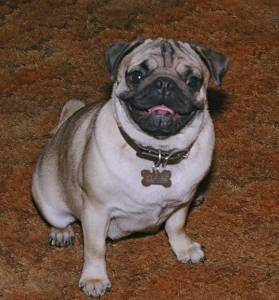

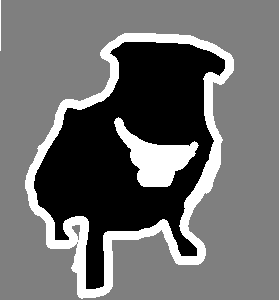

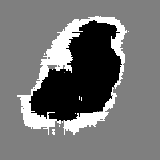

In [ ]:
i = 10
display(Image(filename=val_input_img_paths[i]))

img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

display_mask(i)

In [ ]:
predicted_classes = np.argmax(val_preds[10], axis=-1)
mask_positions = np.where(predicted_classes == 0)
print("경계 픽셀의 (행, 열) 포지션:", mask_positions)

경계 픽셀의 (행, 열) 포지션: (array([ 20,  20,  21,  21,  21,  21,  21,  21,  21,  21,  22,  22,  22,  22,  22,  22,  22,  22,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  26,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28

In [ ]:
print(mask_positions[0][0])
print(mask_positions[1][0])

20
93
